# Motivating Example: SIR Model
{download}`this notebook <./sir.ipynb>`

## Defining the model

First, we are going to go through an SIR model to show the functionality
of the package. The SIR model is defined by the following equations

$$\begin{aligned}
\frac{dS}{dt} &= -\beta SI \\
\frac{dI}{dt} &= \beta SI- \gamma I \\
\frac{dR}{dt} &= \gamma I.
\end{aligned}$$

We can set this up as follows:

1. import the classes required to define the transitions

In [62]:
from pygom import Transition, TransitionType

2. define our states, in this case the population states of **S**usceptible, **I**nfected and **R**emoved

In [63]:
stateList = ['S', 'I', 'R']

3. define the set of parameters for our model, here there are only two

In [64]:
paramList = ['beta', 'gamma']

4. specify the transitions of the modelled states; this will form our ODE system

In [65]:
odeList = [
    Transition(origin='S', equation='-beta*S*I', transition_type=TransitionType.ODE),
    Transition(origin='I',equation='beta*S*I - gamma*I', transition_type=TransitionType.ODE),
    Transition(origin='R', equation='gamma*I', transition_type=TransitionType.ODE) 
    ]

```{note}
Here, we have invoked a class from `Transition` to define the ODE object. We proceed here and ignore the details for now. The details of defining a transition object will be covered later in {doc}`transition`. Both the set of states and parameters should be defined when constructing the object, even though not explicitly enforced, to help clarify what we are trying to model. Similarly, this holds for the rest, such as the derived parameters and transitions, where we force the end user to input the different type of transition/process via the correct argument. See {ref}`transition:defining-the-equations` for an example when the input is wrong.
```


5. import the ode module

In [66]:
from pygom import DeterministicOde

6. initialize the model, which constructs our ODE system from all the information we have provided

In [67]:
model = DeterministicOde(stateList, paramList, ode=odeList)

That is all the information required to define a simple SIR model. We can verify the model using

In [68]:
model.get_ode_eqn()

Matrix([
[         -I*S*beta],
[I*S*beta - I*gamma],
[           I*gamma]])

where we can see the equations corresponding to their respective $S,I$ and $R$ state. 

```{note}
The ordering of the equations is in the standard $S,I,R$ sequence because of how we defined the states initially. 
```

We can rearrange the state list,

In [69]:
# now we are going to define in a different order. note that the output ode changed with the input state
stateList = ['R', 'S', 'I']

model = DeterministicOde(stateList, paramList, ode=odeList)

model.get_ode_eqn()


Matrix([
[           I*gamma],
[         -I*S*beta],
[I*S*beta - I*gamma]])

and find that the set of ODEs comes out in the order that we specified. 

```{tip}
In addition to showing the equation form of the ODEs, we can also display them as either symbols or latex code, which can save some extra typing when porting the equations to another document.
```

In [70]:
model.print_ode()

⎡dR/dt=      I⋅γ    ⎤
⎢                   ⎥
⎢dS/dt=    -I⋅S⋅β   ⎥
⎢                   ⎥
⎣dI/dt=  I⋅S⋅β - I⋅γ⎦


In [71]:
model.print_ode(True)

\begin{array}{cc}dR/dt= & I \gamma\\dS/dt= & - I S \beta\\dI/dt= & I S \beta - I \gamma\end{array}


#TODO links to unroll
Here the SIR model was provided to PyGOM as a set ODEs by using the `Transition` to define them.  
We have also provided the capability to obtain a *best guess* transition matrix when only the ODEs are available. See the section `unrollOde` for more information, and in particular `unrollSimple` for the continuing demonstration of the SIR model.

## Extracting model information

We may wish to determine if the set of ODEs are linear. 

In [72]:
model.linear_ode()

False

Since we know that the SIR model is not linear, we may want to have a look at the Jacobian.


In [73]:
model.get_jacobian_eqn()

Matrix([
[0,       0,          gamma],
[0, -I*beta,        -S*beta],
[0,  I*beta, S*beta - gamma]])

Or maybe we want to know the gradient.

In [74]:
model.get_grad_eqn()

Matrix([
[   0,  I],
[-I*S,  0],
[ I*S, -I]])

```{Warning}
Invoking the functions that compute the derivatives, $f(x)$, `model.ode()` or `model.jacobian()`, will return an error

These functions are used to solve the ODEs numerically, and require values of initial state values, time, and parameter values.
```

For setting initial conditions, the numeric values of the states **must** be set in the same order that list of states appear. We can use the following to check the state ordering, as well as displaying all of the states that we have included.

In [75]:
model.state_list

[ODEVariable('R', 'R', None, True),
 ODEVariable('S', 'S', None, True),
 ODEVariable('I', 'I', None, True)]

#TODO unsure if this is needed
There is currently no mechanism to set the numeric initial conditions the states when the states are defined. This is because of an implementation issue with external package, such as solving an initial value problem.

## Initial value problem

By setting the state initial conditions, time, and parameters, we can evaluate our model.

1. Define the model parameters. (We can call the parameters to check what we must provide.)

In [76]:
model.parameters

In [77]:
paramEval = [('beta',0.5), ('gamma',1.0/3.0)]

model.parameters = paramEval

model.parameters

{beta: 0.5, gamma: 0.3333333333333333}

2. Provide initial conditions for the states.

In [78]:
initialState = [0, 1, 1.27e-6]
    
model.ode(state=initialState, t=1)

array([ 4.23333333e-07, -6.35000000e-07,  2.11666667e-07])


3. Implement an ODE solver.

We are well equipped to solve an initial value problem, using the standard numerical integrator such as `odeint <scipy.integrate.odeint>` from `scipy.integrate`. We also used `matplotlib.pyplot` for plotting and `linspace <numpy.linspace>` to create the time vector.

In [79]:
import scipy.integrate
import numpy

t = numpy.linspace(0, 150, 100)

solution = scipy.integrate.odeint(model.ode, initialState, t)

We can plot our solution to observe a standard SIR shape.

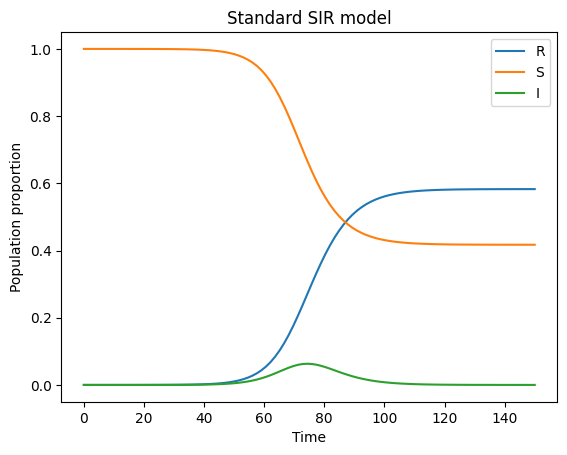

In [80]:
import matplotlib.pyplot as plt

plt.figure()

plt.plot(t, solution[:,0], label='R')

plt.plot(t, solution[:,1], label='S')

plt.plot(t, solution[:,2], label='I')

plt.xlabel('Time')

plt.ylabel('Population proportion')

plt.title('Standard SIR model')

plt.legend(loc=0)

#@savefig sir_plot.png In 

plt.show()

#plt.close()


Alternatively, we can integrate and plot via the **ode** object which we initialized earlier.

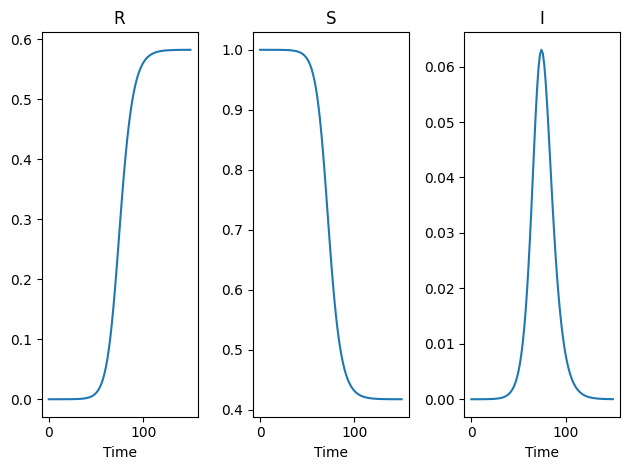

In [81]:
model.initial_values = (initialState, t[0])

model.parameters = paramEval

solution = model.integrate(t[1::])

model.plot()

We could solve the ODEs above using the Jacobian as well. Unfortunately, it does not help because the number of times the Jacobian was evaluated was zero, as expected given that our set of equations are not stiff.

In [82]:
#TODO what does this show?
%timeit solution1, output1 = scipy.integrate.odeint(model.ode, initialState, t, full_output=True)


2.58 ms ± 396 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [83]:

%timeit solution2, output2 = scipy.integrate.odeint(model.ode, initialState, t, Dfun=model.jacobian, mu=None, ml=None, full_output=True)


2.84 ms ± 227 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [84]:

%timeit solution3, output3 = model.integrate(t, full_output=True)

2.68 ms ± 161 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


It is important to note that we return our Jacobian as a dense square matrix. Hence, the two argument (mu,ml) for the ODE solver was set to `None` to let it know the output explicitly.

## Solving the forward sensitivity equation

The sensitivity equations are also solved as an initial value problem. Let us redefine the model in the standard SIR order and we solve it with the sensitivity all set at zero, i.e. we do not wish to infer the initial value of the states.

In [85]:
stateList = ['S', 'I', 'R']

model = DeterministicOde(stateList, paramList, ode=odeList)

initialState = [1, 1.27e-6, 0]

paramEval = [('beta', 0.5), ('gamma', 1.0/3.0)]

model.parameters = paramEval

solution = scipy.integrate.odeint(model.ode_and_sensitivity, numpy.append(initialState, numpy.zeros(6)), t)

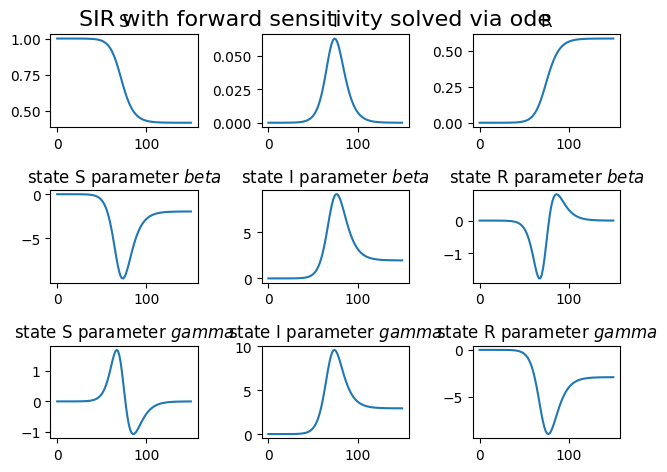

In [87]:
{
    "tags": [
        "hide-input",
    ]
}
f,axarr = plt.subplots(3,3);

f.text(0.5,0.975,'SIR with forward sensitivity solved via ode',fontsize=16,horizontalalignment='center',verticalalignment='top')

axarr[0,0].plot(t, solution[:,0])

axarr[0,0].set_title('S')

axarr[0,1].plot(t, solution[:,1])

axarr[0,1].set_title('I')

axarr[0,2].plot(t, solution[:,2]);

axarr[0,2].set_title('R')

axarr[1,0].plot(t, solution[:,3])

axarr[1,0].set_title(r'state S parameter $beta$')

axarr[2,0].plot(t, solution[:,4])

axarr[2,0].set_title(r'state S parameter $gamma$')

axarr[1,1].plot(t, solution[:,5])

axarr[1,1].set_title(r'state I parameter $beta$')

axarr[2,1].plot(t, solution[:,6])

axarr[2,1].set_title(r'state I parameter $gamma$')

axarr[1,2].plot(t, solution[:,7])

axarr[1,2].set_title(r'state R parameter $beta$')

axarr[2,2].plot(t, solution[:,8])

axarr[2,2].set_title(r'state R parameter $gamma$')

plt.tight_layout()

plt.show()

#TODO links
This concludes the introductory example and we will be moving on to look at parameter estimation next in {doc}`estimate1` and the most important part in terms of setting up the ODE object; defining the equations in various different ways in {doc}`transition`.